In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import BasicProcessor as bp

In [3]:
if '../Tracker' not in sys.path: sys.path.append('../Tracker')
import Tracker as t

In [4]:
mpl.rcParams.update({'font.size': 14})

In [6]:
df, sf = bp.load_data_summary()
df.shape, sf.shape

((82091, 78), (186746, 104))

In [9]:
vf = pd.read_csv(r'../Photographer/videos_metadata.csv', index_col=0)
vf

,video,size_mb,len_minutes,date,time,weekday
20190520_105429.mp4,20190520_105429.mp4,115.474790,7.231111,20190520,10.908056,2
20190520_112342.mp4,20190520_112342.mp4,522.146511,32.755556,20190520,11.395000,2
20190520_141707.mp4,20190520_141707.mp4,129.201198,8.102222,20190520,14.285278,2
20190520_151643.mp4,20190520_151643.mp4,134.681172,8.435556,20190520,15.278611,2
20190520_171559.mp4,20190520_171559.mp4,166.763672,10.453333,20190520,17.266389,2
...,...,...,...,...,...,...
20190703_193828_protest.2.mp4,20190703_193828_protest.2.mp4,84.800777,5.320000,20190703,19.641111,4
20190705_085717_parking.enter.queue.mp4,20190705_085717_parking.enter.queue.mp4,97.129501,6.088889,20190705,8.954722,6
20190705_101321.mp4,20190705_101321.mp4,105.950683,6.644444,20190705,10.222500,6
20190706_005745.mp4,20190706_005745.mp4,169.395233,10.626667,20190706,0.962500,7


In [7]:
nf = bp.detections_count()
nf

,video,n_frames,n_detections,detections_per_frame
20190520_105429,20190520_105429,1627,28986,17.8156
20190520_112342,20190520_112342,7370,87822,11.9161
20190520_141707,20190520_141707,1823,41040,22.5123
20190520_151643,20190520_151643,1898,61264,32.2782
20190520_171559,20190520_171559,2352,37159,15.7989
...,...,...,...,...
20190703_193828_protest.2,20190703_193828_protest.2,1197,5729,4.78613
20190705_085717_parking.enter.queue,20190705_085717_parking.enter.queue,1370,11195,8.17153
20190705_101321,20190705_101321,1495,13200,8.82943
20190706_005745,20190706_005745,2391,6505,2.72062


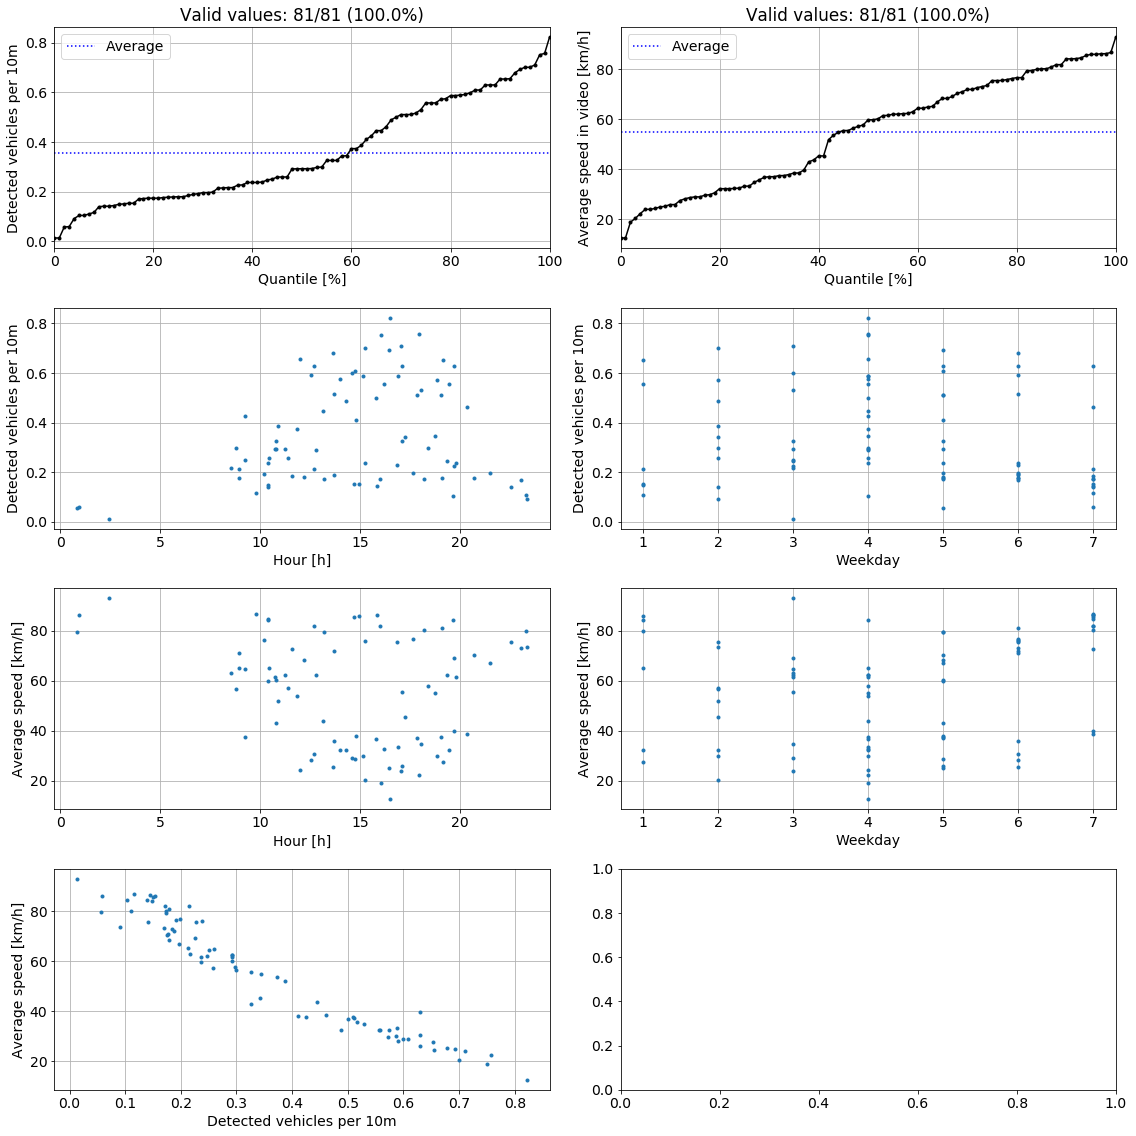

In [33]:
_, axs = plt.subplots(4,2, figsize=(16,16))

n_lanes = 5
road_len = df.max_x.max()-0 # (min_x has some weird outlier)

speeds = 3.6*df.groupby('video')['abs_v'].apply(np.mean)

ax = axs[0,0]
t.qplot(nf.detections_per_frame / (n_lanes*road_len/10), ax=ax, ylab='Detected vehicles per 10m')

ax = axs[0,1]
t.qplot(speeds, ax=ax, ylab='Average speed in video [km/h]')

ax = axs[1,0]
ax.plot(vf.time, nf.detections_per_frame / (n_lanes*road_len/10), '.')
ax.set_xlabel('Hour [h]')
ax.set_ylabel('Detected vehicles per 10m')
ax.grid()

ax = axs[1,1]
ax.plot(vf.weekday, nf.detections_per_frame / (n_lanes*road_len/10), '.')
ax.set_xlabel('Weekday')
ax.set_ylabel('Detected vehicles per 10m')
ax.grid()

ax = axs[2,0]
ax.plot(vf.time, speeds, '.')
ax.set_xlabel('Hour [h]')
ax.set_ylabel('Average speed [km/h]')
ax.grid()

ax = axs[2,1]
ax.plot(vf.weekday, speeds, '.')
ax.set_xlabel('Weekday')
ax.set_ylabel('Average speed [km/h]')
ax.grid()

ax = axs[3,0]
ax.plot(nf.detections_per_frame / (n_lanes*road_len/10), speeds, '.')
ax.set_xlabel('Detected vehicles per 10m')
ax.set_ylabel('Average speed [km/h]')
ax.grid()

plt.tight_layout()

In [21]:
vf[vf.time<10].sort_values('time')

,video,size_mb,len_minutes,date,time,weekday
20190523_005006.mp4,20190523_005006.mp4,138.442708,8.680000,20190523,0.835000,5
20190706_005745.mp4,20190706_005745.mp4,169.395233,10.626667,20190706,0.962500,7
20190604_022732.mp4,20190604_022732.mp4,284.962529,17.871111,20190604,2.458889,3
20190611_083417.mp4,20190611_083417.mp4,147.632916,9.253333,20190611,8.571389,3
20190617_084652.mp4,20190617_084652.mp4,124.487805,7.804444,20190617,8.781111,2
20190705_085717_parking.enter.queue.mp4,20190705_085717_parking.enter.queue.mp4,97.129501,6.088889,20190705,8.954722,6
20190616_085753.mp4,20190616_085753.mp4,249.334395,15.631111,20190616,8.964722,1
20190529_091346.mp4,20190529_091346.mp4,326.640622,20.488889,20190529,9.229444,4
20190625_091524.mp4,20190625_091524.mp4,106.827107,6.688889,20190625,9.256667,3
20190622_094921.mp4,20190622_094921.mp4,129.388526,8.115556,20190622,9.822500,7


In [26]:
nf[(6<vf.time.values) & (vf.time.values<9)].detections_per_frame / (n_lanes*road_len/10)

20190611_083417                        0.216029
20190616_085753                        0.213432
20190617_084652                        0.298811
20190705_085717_parking.enter.queue    0.177346
Name: detections_per_frame, dtype: object